In [10]:
import time
import copy
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

torch.manual_seed(17)

# Data preparation

In [11]:
transform = transforms.Compose([ 
    transforms.Resize((224, 224)), 
    transforms.ToTensor()
])

In [12]:
dataset = torchvision.datasets.ImageFolder('../input/tiny-imagenet/tiny-imagenet-200/train', transform=transform)


In [13]:
#split the data
train_data, val_data, test_data = torch.utils.data.random_split(dataset, [80000, 10000, 10000])

In [14]:
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=4)

Visualise training images

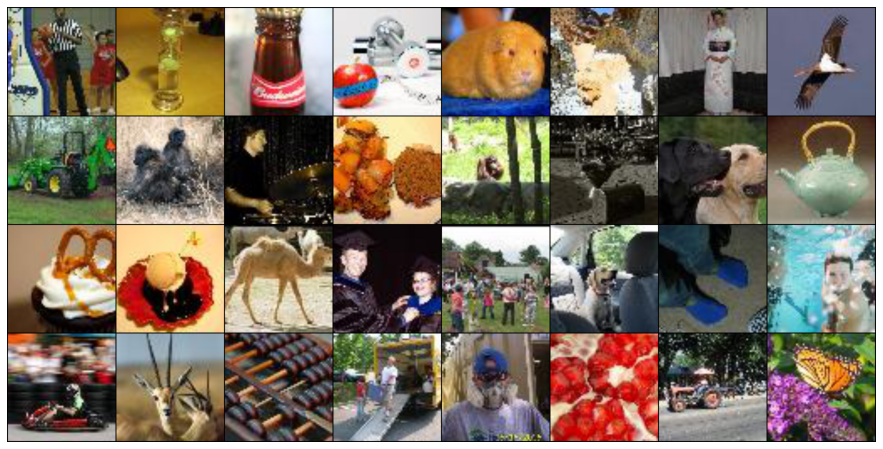

In [15]:
from torchvision.utils import make_grid

for images, _ in train_loader:
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=8).permute((1, 2, 0)))
    break

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import os
# Custom Neural Network with additional layers
class CustomResNet(nn.Module):
    def __init__(self, num_classes=1000):
        super(CustomResNet, self).__init__()
        self.model = models.resnet50(pretrained=True)
        self.model.fc = nn.Sequential(
            nn.Linear(self.model.fc.in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.model(x)

# Initialize the model
model = CustomResNet(num_classes=1000)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Optimization Loop
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

num_epochs = 5
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)
        # Loss calculation
        loss = criterion(outputs, labels)
        # Zero gradients
        optimizer.zero_grad()
        # Backpropagation
        loss.backward()
        # Update optimizer
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

        # Calculate training accuracy
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader.dataset)
    train_accuracy = 100.0 * correct_train / total_train
    train_losses.append(epoch_loss)

    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            
            # Calculate validation accuracy
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
    
    epoch_val_loss = val_loss / len(val_loader.dataset)
    val_accuracy = 100.0 * correct_val / total_val
    val_losses.append(epoch_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {epoch_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")


Epoch 1/5, Train Loss: 3.3333, Train Accuracy: 30.82%, Val Loss: 1.3145, Val Accuracy: 67.39%
Epoch 2/5, Train Loss: 1.3519, Train Accuracy: 65.92%, Val Loss: 1.0389, Val Accuracy: 72.84%
Epoch 3/5, Train Loss: 0.9237, Train Accuracy: 75.98%, Val Loss: 1.0245, Val Accuracy: 73.48%
Epoch 4/5, Train Loss: 0.6723, Train Accuracy: 81.82%, Val Loss: 1.0223, Val Accuracy: 74.37%
Epoch 5/5, Train Loss: 0.5001, Train Accuracy: 86.24%, Val Loss: 1.0724, Val Accuracy: 73.82%


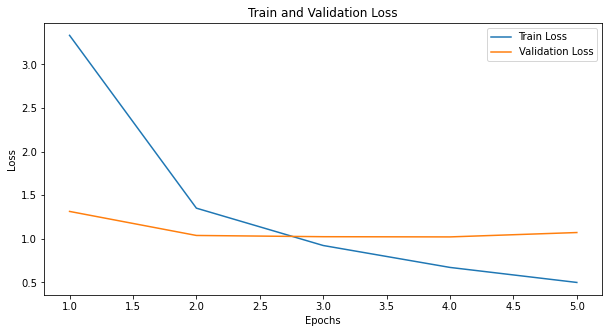

In [20]:

# Plot the loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Train and Validation Loss')
plt.show()